In [1]:
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2000-12-31 00:00:00
365


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

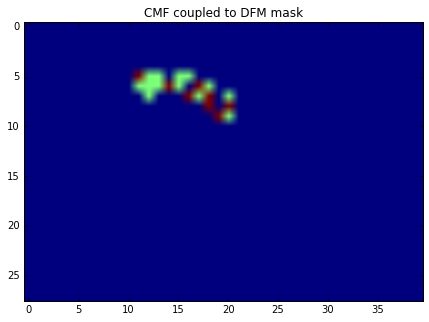

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
b.set_title('CMF coupled to DFM mask')

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [11]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [12]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-05 13:25:55.942591
2018-03-05 13:25:55,948 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-05 13:25:55.942591
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-05T13:25:55.942591.log
2018-03-05 13:25:55,949 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-05T13:25:55.942591.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-05 13:25:55,951 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this

## define exchange of values in update states function

In [13]:
def get_CMF_delta_vol():
    # coupled 2d mask
    mask = (CMF_bmi.coupled_mask > 0).astype(float)
    # total Q inflow 2D for coupled cells
    q_in = (CMF_bmi.get_var('rivinf') + CMF_bmi.get_var('fldinf')) * mask # [m3/s]
    # total CMF converted runoff inflow 2D for coupled cells
    runoff = CMF_bmi.get_var('runoff') * mask # [m3/s]
    # take Qin + runoff in most upstream coupled cells, only runoff for other cells
    tot_flux = np.where(CMF_bmi.coupled_mask == 2, q_in + runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * CMF_bmi.options['dt'] # [m3/day]
    return delta_vol 

def set_CMF_forcing():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff') # [m/day]
    runoff = np.where(np.isnan(runoff), 0, runoff)
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = get_CMF_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
        

## run coupled CMF - DFM model

In [14]:
# run coupled model for 2 timesteps
# for i in range(2):
# run for numer of timesteps specified in set-file
tStart = datetime.now()
for i in range(timeSteps):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()
tEnd = datetime.now()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-05 13:26:10,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-05 13:26:10,841 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-05 13:26:13,054 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-05 13:26:13,078 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-05 13:26:13,590 coupling_PCR_FM.model_functions_v2 INFO DFM -> 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-05 13:26:29,249 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-05 13:26:29,263 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-05 13:26:29,647 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-05 13:26:30,760 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-03-05 13:26:30,906 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-03-05 13:26:47,108 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-05 13:26:48,210 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-05 13:26:48,218 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-05 13:26:48,684 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-05 13:26:49,846 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-05 13:27:11,216 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
2018-03-05 13:27:11,279 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-05 13:27:12,701 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-05 13:27:12,704 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-05 13:27:13,086 pcrglo

2018-03-05 13:27:35,495 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-05 13:27:35,926 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-05 13:27:37,396 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
2018-03-05 13:27:37,532 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-05 13:27:38,829 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-05 13:28:03,048 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-05 13:28:03,062 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-05 13:28:03,454 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-05 13:28:04,614 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-05 13:28:04,648 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
2018-03-05 13:28:33,282 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-05 13:28:34,899 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-05 13:28:34,901 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-05 13:28:35,260 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-05 13:28:36,407 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-05 13:28:58,227 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
2018-03-05 13:28:58,292 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-05 13:28:59,401 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-05 13:28:59,404 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-05 13:28:59,850 pcrglo

2018-03-05 13:29:23,018 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-05 13:29:23,505 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-05 13:29:24,648 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
2018-03-05 13:29:24,698 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-05 13:29:26,694 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-05 13:29:49,413 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-05 13:29:49,416 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-05 13:29:49,795 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-05 13:29:50,966 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-05 13:29:51,074 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
2018-03-05 13:30:14,846 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-05 13:30:16,397 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-05 13:30:16,400 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-05 13:30:16,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-05 13:30:17,958 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-05 13:30:42,757 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
2018-03-05 13:30:42,861 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-05 13:30:44,065 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-05 13:30:44,071 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-05 13:30:44,480 pcrglo

2018-03-05 13:31:03,706 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-05 13:31:04,087 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-05 13:31:05,264 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
2018-03-05 13:31:05,305 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-05 13:31:06,405 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-05 13:31:28,560 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-05 13:31:28,575 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-05 13:31:28,969 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-05 13:31:30,154 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-12 00:00:00, timestep 86400.0
2018-03-05 13:31:30,225 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-05 13:31:52,524 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-05 13:31:54,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-05 13:31:54,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-05 13:31:54,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-05 13:31:55,865 coupling_PCR_FM.model_functions_v2 INFO PCR -

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-05 13:32:16,349 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
2018-03-05 13:32:16,412 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-05 13:32:17,618 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-05 13:32:17,620 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-05 13:32:17,996 pc

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-05 13:32:37,885 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-05 13:32:38,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-05 13:32:39,448 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
2018-03-05 13:32:39,495 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-05 13:32:40,182 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-05 13:33:02,229 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-05 13:33:02,232 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-05 13:33:02,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-05 13:33:03,774 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-13 00:00:00, timestep 86400.0
2018-03-05 13:33:03,824 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-05 13:33:26,814 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-05 13:33:28,003 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-05 13:33:28,005 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-05 13:33:28,480 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-05 13:33:29,671 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:33:53,807 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-05 13:33:54,998 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-05 13:33:55,076 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-05 13:33:57,161 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-05 13:33:57,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-05 13:34:20,185 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-05 13:34:20,620 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-05 13:34:21,767 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
2018-03-05 13:34:21,922 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-05 13:34:23,537 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-05 13:34:46,517 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-05 13:34:46,519 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-05 13:34:46,998 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-05 13:34:48,283 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-13 00:00:00, timestep 86400.0
2018-03-05 13:34:48,351 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
2018-03-05 13:35:14,381 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-05 13:35:16,948 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-05 13:35:16,954 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-05 13:35:17,441 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-05 13:35:18,659 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:35:41,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-05 13:35:42,885 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
2018-03-05 13:35:42,951 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-05 13:35:45,125 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-05 13:35:45,133 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-05 13:36:09,458 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-05 13:36:09,906 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-05 13:36:11,067 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
2018-03-05 13:36:11,178 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-05 13:36:13,334 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-05 13:36:34,579 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-05 13:36:34,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-05 13:36:34,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-05 13:36:36,183 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-14 00:00:00, timestep 86400.0
2018-03-05 13:36:36,351 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
2018-03-05 13:37:02,912 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-05 13:37:05,446 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-05 13:37:05,461 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-05 13:37:05,864 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-05 13:37:07,047 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:37:31,455 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-05 13:37:32,642 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
2018-03-05 13:37:32,714 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-05 13:37:33,882 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-05 13:37:33,889 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-05 13:37:56,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-05 13:37:57,208 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-05 13:37:58,387 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
2018-03-05 13:37:58,453 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-05 13:38:00,722 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-05 13:38:26,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-05 13:38:26,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-05 13:38:27,359 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-05 13:38:28,572 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-14 00:00:00, timestep 86400.0
2018-03-05 13:38:28,648 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
2018-03-05 13:38:52,558 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-05 13:38:54,616 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-05 13:38:54,618 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-05 13:38:55,003 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-05 13:38:56,251 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:39:18,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-05 13:39:19,511 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
2018-03-05 13:39:19,573 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-05 13:39:20,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-05 13:39:20,446 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-05 13:39:44,711 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-05 13:39:45,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-05 13:39:46,331 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-05 13:39:46,419 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-05 13:39:48,116 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-05 13:40:15,373 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-05 13:40:15,375 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-05 13:40:15,813 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-05 13:40:17,039 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-05 13:40:17,127 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
2018-03-05 13:40:40,933 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-05 13:40:41,854 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-05 13:40:41,858 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-05 13:40:42,324 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-05 13:40:43,562 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:41:04,513 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-05 13:41:05,734 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
2018-03-05 13:41:05,843 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-05 13:41:07,847 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-05 13:41:07,849 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-05 13:41:33,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-05 13:41:33,561 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-05 13:41:34,779 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
2018-03-05 13:41:34,833 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-05 13:41:36,254 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-05 13:42:00,844 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-05 13:42:00,848 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-05 13:42:01,299 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-05 13:42:02,482 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-05 13:42:02,545 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
2018-03-05 13:42:25,942 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-05 13:42:27,473 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-05 13:42:27,476 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-05 13:42:27,891 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-05 13:42:29,114 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:42:50,926 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-05 13:42:52,181 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
2018-03-05 13:42:52,316 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-05 13:42:53,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-05 13:42:53,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-05 13:43:17,999 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-05 13:43:18,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-05 13:43:19,573 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
2018-03-05 13:43:19,650 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-05 13:43:20,577 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-05 13:43:43,343 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-05 13:43:43,346 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-05 13:43:43,775 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-05 13:43:44,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-15 00:00:00, timestep 86400.0
2018-03-05 13:43:45,027 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-05 13:44:06,266 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-05 13:44:06,998 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-05 13:44:07,001 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-05 13:44:07,473 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-05 13:44:08,678 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:44:28,523 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-05 13:44:29,740 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
2018-03-05 13:44:30,007 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-05 13:44:31,069 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-05 13:44:31,070 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-05 13:44:53,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-05 13:44:53,701 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-05 13:44:54,923 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
2018-03-05 13:44:55,016 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-05 13:44:56,432 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-05 13:45:17,413 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-05 13:45:17,419 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-05 13:45:17,872 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-05 13:45:19,094 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-16 00:00:00, timestep 86400.0
2018-03-05 13:45:19,190 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-05 13:45:42,224 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-05 13:45:43,848 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-05 13:45:43,855 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-05 13:45:44,318 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-05 13:45:45,550 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-05 13:46:06,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-05 13:46:07,871 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-05 13:46:07,908 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-05 13:46:09,111 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0


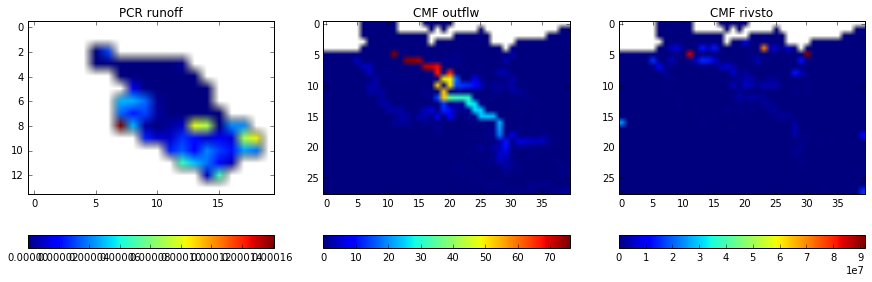

In [15]:
runoff = np.copy(PCR_bmi.get_var('landSurfaceRunoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [16]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-05 13:26:10.580859
end time coupling:  2018-03-05 13:46:09.114778
average time per update PCR->CMF->DFM:  0:00:03.283654


## Finalize models

In [17]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()


INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-05 13:46:10,208 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-05 13:46:10,210 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## Finalize models

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM/DFM_OUTPUT_DFM_Elbe_VU/DFM_Elbe_VU_his.nc


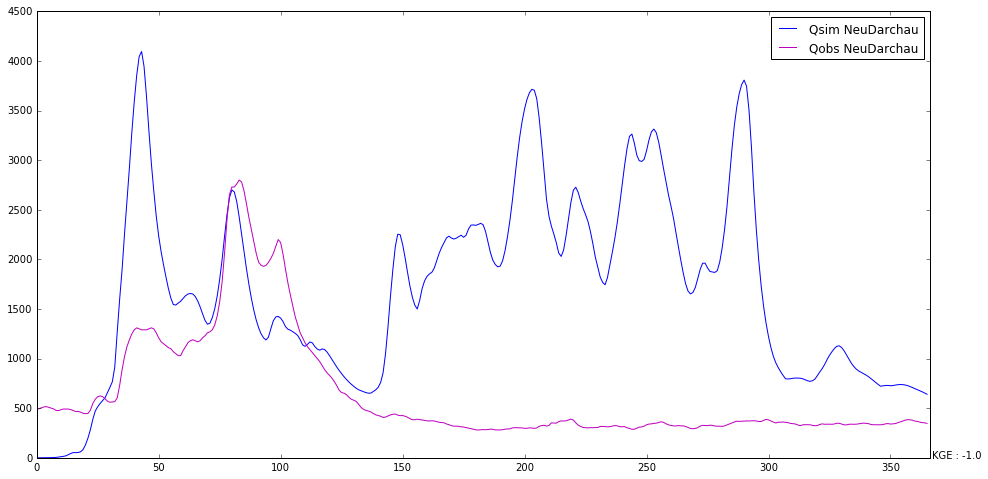

In [26]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
print fo
vo = os.path.join(DFM_out_dir, 'Elbe-W+Q.csv')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- extract simulated discharge from nc-file
no = Dataset(fo, 'r')
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

if len(qobs_ND) > len(qsim_ND):
    qobs_ND = qobs_ND[:len(qsim_ND)]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'Qsim NeuDarchau')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(qobs_ND, 'm', label = 'Qobs NeuDarchau')
plt.text(len(qsim_ND)+1,1, 'KGE : '+str(KGE_ND))
plt.legend(loc=1)
plt.xlim(0, len(qsim_ND))
plt.savefig(os.path.join(DFM_out_dir, 'Qsim_DFM_NeuDarchau_after_'+str(timeSteps)+'timeSteps.png'), dpi=300)